# Objective 2.2 (A) -  Interaction analysis (effect modification)


## Step 1: Import and Set Up

***Setting things up before starting the real work***

So here, I’m just setting up everything I need before I dive into the actual data stuff. I’m loading some important tools that’ll help me look at the data, make graphs, and run some analysis later on. I’m also telling the system where to find certain folders, like where the data is and where to save results. Finally, I’m making sure that when I look at tables, I can see all the columns properly. That’s it—just getting ready to go.

In [1]:
# Setup environment and imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# Add the 'scripts' folder to the Python path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))

from config import (
    FINAL_DATA_DIR,
    SUMMARY_DIR,
    PLOTS_DIR   
)

from utils import pretty_path

# Display full columns in pandas
pd.set_option('display.max_columns', None)

print("Setup complete.")


Setup complete.


## STEP 2: Load the complete merged NHANES Dataset

***Loading the main dataset to start exploring***

Here I'm just pulling in the main dataset I'll be working with. I'm checking if the file is actually there first—just in case. Once it's loaded, I take a quick look at the first few rows to see what the data looks like, and also print out the shape to know how many rows and columns I've got to work with.

In [2]:
# Read the csv file into the dataframe

file_path = FINAL_DATA_DIR / "final_merged_nhanes_dataset.csv"
if not file_path.exists():
    raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv(file_path)

# preview the first few rows of a DataFrame.
print(df.head())
print(df.shape)

   participant_id  age  gender      race_ethnicity            education_level  \
0          130378   43    Male  Non-Hispanic Asian  College graduate or above   
1          130379   66    Male  Non-Hispanic White  College graduate or above   
2          130380   44  Female      Other Hispanic            High school/GED   
3          130386   34    Male    Mexican American     Some college/AA degree   
4          130387   68  Female  Non-Hispanic White  College graduate or above   

   poverty_income_ratio pir_category  interview_sample_weight  psu  strata  \
0                  5.00    Very High             50055.450807  2.0   173.0   
1                  5.00    Very High             29087.450605  2.0   173.0   
2                  1.41          Mid             80062.674301  1.0   174.0   
3                  1.33          Mid             30995.282610  1.0   179.0   
4                  1.32          Mid             19896.970559  1.0   181.0   

  has_health_insurance  sleep_avg_hr sleep_c

## STEP 3: Data analysis and visualization

### 1a. Model Interaction Effect - how income and gender together affect obesity 

***Checking how income and gender together affect obesity***

In this part, I’m preparing the data to look at how income level (PIR category) and gender work together when it comes to obesity. I start by cleaning the data—keeping only the columns I need and dropping any rows with missing values. Then, I run a logistic regression that includes an interaction between income and gender, so I can see if the link between income and obesity is different for men and women. I use survey weights to make sure the results reflect the population properly, and I apply HC3 robust standard errors to help make the results more reliable, especially since the data comes from a complex survey. Finally, I save the results to a text file for later review.

In [3]:
# Prepare the data 
model_df = df[['obese', 'pir_category', 'gender', 'exam_sample_weight']].dropna()

# Fit logistic regression model with interaction using formula 
model = smf.glm(
    formula='obese ~ C(pir_category) * C(gender)',  
    data=model_df,
    family=sm.families.Binomial(),
    freq_weights=model_df['exam_sample_weight']
)

results = model.fit(cov_type='HC3')
print(results.summary())

# Save summary
summary_txt_path = SUMMARY_DIR / "obj_2.2_pir_gender_obesity_interaction_analysis.txt"
with open(summary_txt_path, 'w') as f:
    f.write(results.summary().as_text())

print(f"pir_gender_obesity regression summary saved to {pretty_path(summary_txt_path)}")



                 Generalized Linear Model Regression Results                  
Dep. Variable:                  obese   No. Observations:                 5970
Model:                            GLM   Df Residuals:             241937104.31
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6190e+08
Date:                Sat, 26 Jul 2025   Deviance:                   3.2381e+08
Time:                        14:38:46   Pearson chi2:                 2.42e+08
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### 1b. Model Interaction Effect - how income and gender together affect obesity  - Visualization

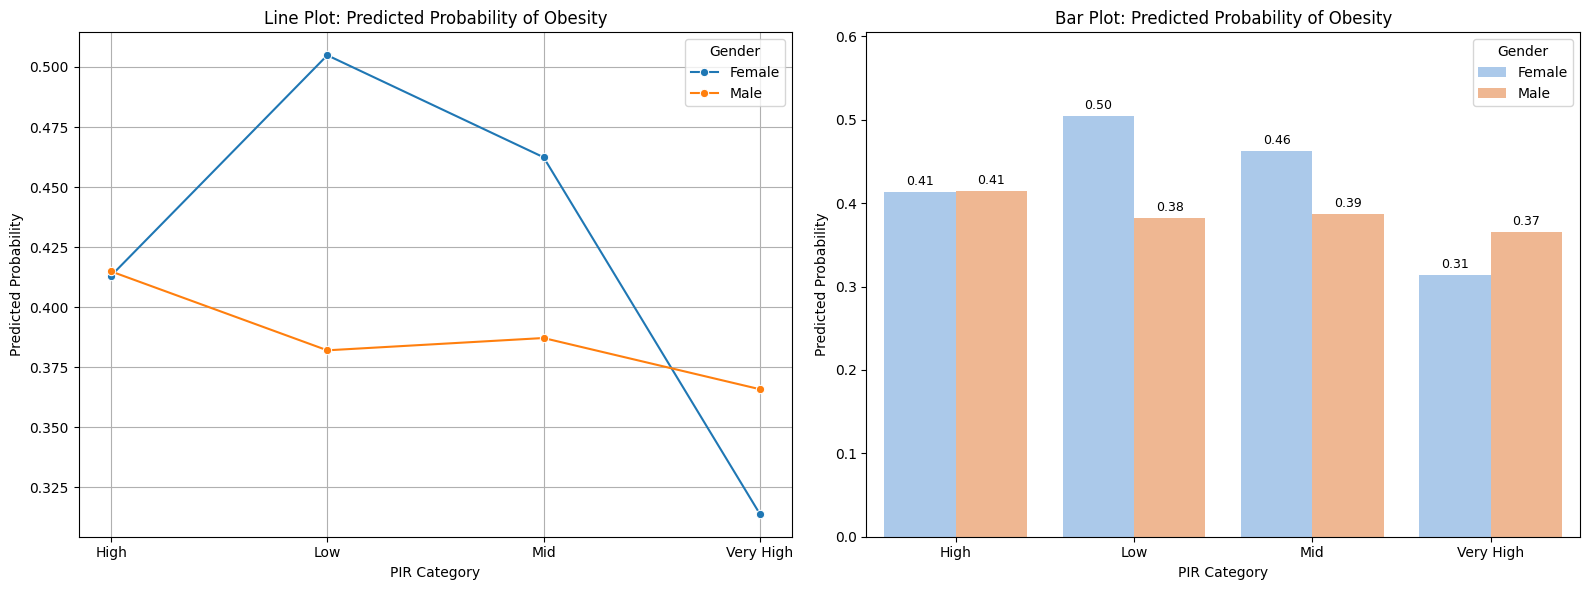

Combined_pir_gender_obesity_interaction_analysis_plot saved to: outputs\plots\obj_2.2_pir_gender_obesity_interaction_analysis.png


In [4]:
# Copy model_df
viz_df = model_df.copy()

# Predict probability of obesity
viz_df['predicted_prob'] = results.predict(viz_df)

# Average predicted probabilities
plot_df = viz_df.groupby(['pir_category', 'gender'])['predicted_prob'].mean().reset_index()

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# --- Line plot ---
sns.lineplot(
    data=plot_df,
    x='pir_category',
    y='predicted_prob',
    hue='gender',
    marker='o',
    ax=ax1
)
ax1.set_title('Line Plot: Predicted Probability of Obesity')
ax1.set_xlabel('PIR Category')
ax1.set_ylabel('Predicted Probability')
ax1.legend(title='Gender')
ax1.grid(True)

# --- Bar plot ---
sns.barplot(
    data=plot_df,
    x='pir_category',
    y='predicted_prob',
    hue='gender',
    palette='pastel',
    ax=ax2
)

# Add value labels on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=3)

ax2.set_title('Bar Plot: Predicted Probability of Obesity')
ax2.set_xlabel('PIR Category')
ax2.set_ylabel('Predicted Probability')
ax2.set_ylim(0, plot_df['predicted_prob'].max() + 0.1)
ax2.legend(title='Gender')

plt.tight_layout() 

combined_plot_path = PLOTS_DIR/'obj_2.2_pir_gender_obesity_interaction_analysis.png'

# Save to file
plt.savefig(combined_plot_path, dpi=300)

# Show the plots
plt.show()
plt.close()
print(f"Combined_pir_gender_obesity_interaction_analysis_plot saved to: {pretty_path(combined_plot_path)}")


### 2a. The interaction between sleep duration and race/ethnicity on BMI,using a weighted linear regression (WLS) Model

***How sleep and race together relate to BMI***

I am checking whether the link between sleep and BMI is different across racial and ethnic groups. I use a cleaned-up version of the data that includes BMI, average sleep hours, race/ethnicity, and sample weights. To make the results easier to interpret, I center the sleep variable by subtracting the average sleep hours. Then I build a formula that lets me test whether the effect of sleep on BMI changes depending on someone's race or ethnicity. 
I run a weighted linear regression using that formula, and to make the results more reliable—especially since the data comes from a complex survey—I use something called HC3 robust standard errors. Finally, I save the results so I can review them later.

In [5]:
# 1. Prepare the data
interaction_df = df[['bmi', 'sleep_avg_hr', 'race_ethnicity', 'exam_sample_weight']].dropna()

# center sleep for interpretability
interaction_df['sleep_avg_hr_c'] = interaction_df['sleep_avg_hr'] - interaction_df['sleep_avg_hr'].mean()

# 2. Build the formula dynamically
main_var = 'sleep_avg_hr_c'
cat_var = 'race_ethnicity'
target = 'bmi'

formula = f"{target} ~ {main_var} * C({cat_var})"

# 3. Fit the model with weights
model = smf.wls(formula=formula, data=interaction_df, weights=interaction_df['exam_sample_weight'])
results = model.fit(cov_type='HC3')

print(results.summary())

# Save summary
summary_txt_path = SUMMARY_DIR / "obj_2.2_sleep_bmi_by_race.txt"
with open(summary_txt_path, 'w') as f:
    f.write(results.summary().as_text())
print(f"sleep_bmi_by_race summary saved to {pretty_path(summary_txt_path)}")



                            WLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     26.54
Date:                Sat, 26 Jul 2025   Prob (F-statistic):           1.20e-54
Time:                        14:38:47   Log-Likelihood:                -20611.
No. Observations:                5897   AIC:                         4.125e+04
Df Residuals:                    5885   BIC:                         4.133e+04
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

### 2b. The interaction between sleep duration and race/ethnicity on BMI,using a weighted linear regression (WLS) Model - Visualization

***How Sleep and Race Together Affect BMI — Visualizing the Interaction***

Now, I'm making some plots to show how sleep and race work together when it comes to BMI. I start by creating predicted BMI values for different sleep amounts across each race group using the model we ran earlier.

The first plot shows predicted BMI changing with sleep for each race group, letting us see how the relationship might be different between groups.

The second plot breaks things down by race, showing the actual data points and the model’s prediction line in each panel. This gives a clearer picture of how sleep relates to BMI within each race/ethnicity group.

I save these plots so we can look at them anytime and understand the patterns visually.

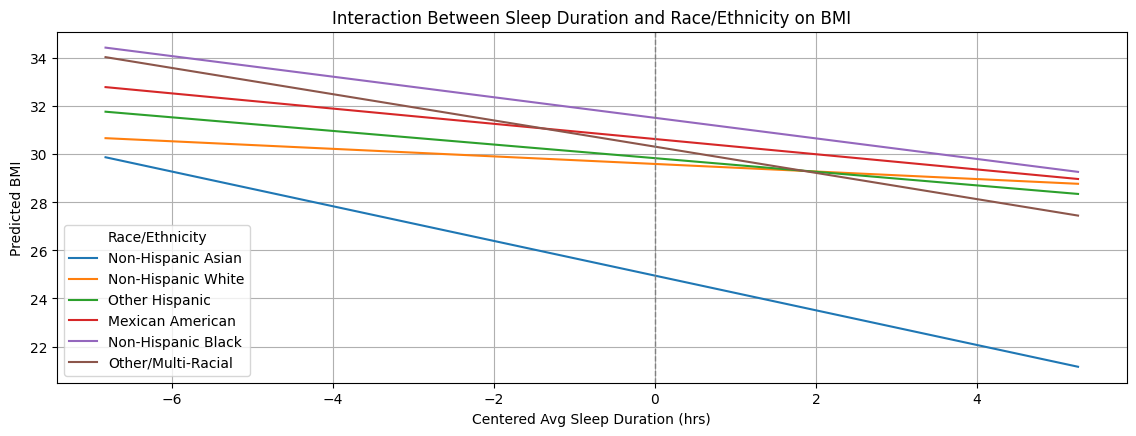

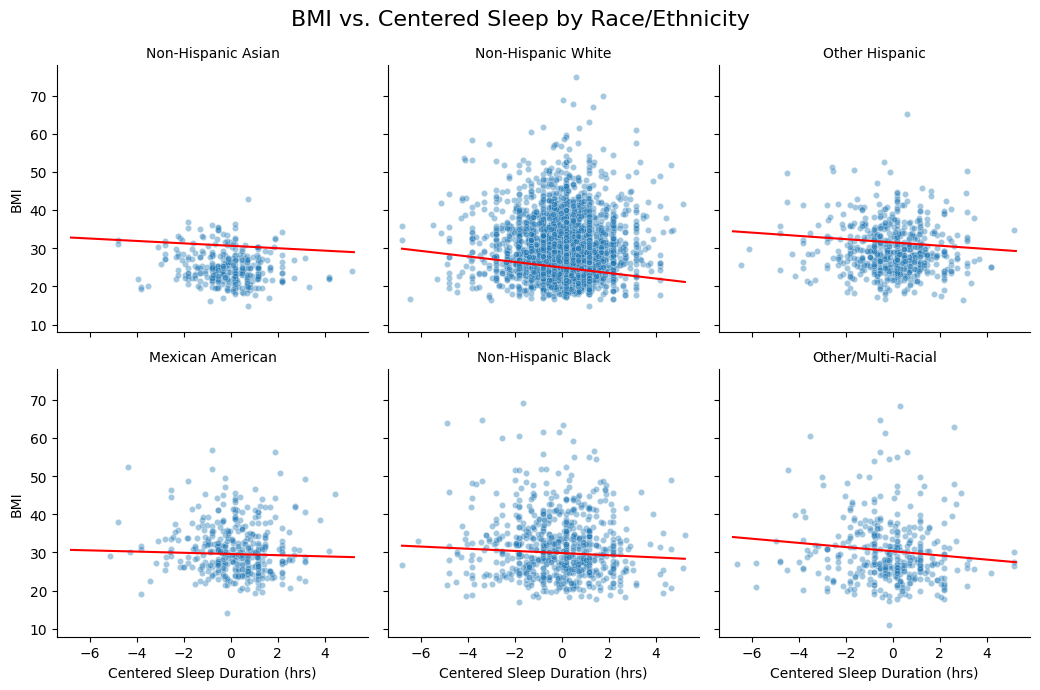

Combined_sleep_bmi_interaction_plot saved to: outputs\plots\obj_2.2_combined_sleep_bmi_interaction_plot.png


In [6]:
# Ensure centered sleep column exists
if 'sleep_avg_hr_c' not in interaction_df.columns:
    interaction_df['sleep_avg_hr_c'] = interaction_df['sleep_avg_hr'] - interaction_df['sleep_avg_hr'].mean()

# Create prediction values
sleep_vals = np.linspace(interaction_df['sleep_avg_hr_c'].min(), interaction_df['sleep_avg_hr_c'].max(), 100)
predict_df = pd.DataFrame([
    {'sleep_avg_hr_c': val, 'race_ethnicity': race}
    for race in interaction_df['race_ethnicity'].unique()
    for val in sleep_vals
])
predict_df['predicted_bmi'] = results.predict(predict_df)

# --- PLOT 1: Line Plot ---
fig, ax1 = plt.subplots(figsize=(12, 5))  # First row

sns.lineplot(
    data=predict_df,
    x='sleep_avg_hr_c',
    y='predicted_bmi',
    hue='race_ethnicity',
    palette='tab10',
    ax=ax1
)

ax1.set_title('Interaction Between Sleep Duration and Race/Ethnicity on BMI')
ax1.set_xlabel('Centered Avg Sleep Duration (hrs)')
ax1.set_ylabel('Predicted BMI')
ax1.axvline(0, color='gray', linestyle='--', linewidth=1)
ax1.grid(True)
ax1.legend(title='Race/Ethnicity')

plt.tight_layout(pad=3)

# --- PLOT 2: Faceted Scatter + Model Line Plot ---
g = sns.FacetGrid(interaction_df, col='race_ethnicity', col_wrap=3, height=3.5, sharex=True, sharey=True)

g.map_dataframe(sns.scatterplot, x='sleep_avg_hr_c', y='bmi', alpha=0.4, s=20)

# Overlay model predictions
for ax, (race, group_df) in zip(g.axes.flat, predict_df.groupby('race_ethnicity')):
    ax.plot(group_df['sleep_avg_hr_c'], group_df['predicted_bmi'], color='red', label='Model Prediction')

g.set_axis_labels("Centered Sleep Duration (hrs)", "BMI")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("BMI vs. Centered Sleep by Race/Ethnicity", fontsize=16)
combined_plot_path = PLOTS_DIR / "obj_2.2_combined_sleep_bmi_interaction_plot.png"
# Save final combined image
g.fig.savefig(combined_plot_path, dpi=300)
plt.show()
plt.close()
print(f"Combined_sleep_bmi_interaction_plot saved to: {pretty_path(combined_plot_path)}")


### 3a. Interaction model Diet and Gender on Cholesterol 

***How Diet Affects Cholesterol — Does Gender Matter?***

I wanted to see if eating better (as measured by HEI score) is linked to cholesterol levels, and more interestingly, whether that relationship is different for men and women. So, I took the relevant data — cholesterol levels, diet scores, gender, and the proper sample weights — and cleaned it up by dropping any rows with missing info. Then I centered the HEI score to make the results easier to interpret. Next, I built a regression model that looks at diet score, gender, and their interaction. The interaction term is key — it tells us if the effect of diet on cholesterol is stronger (or weaker) depending on whether you're male or female. I used weighted regression to make sure the results reflect the population properly. After fitting the model, I saved the full output to a text file. That summary includes things like which variables were significant and how big their effects were. This gives us a clearer picture of whether healthy eating benefits everyone equally — or if there’s a gender difference in how diet impacts cholesterol.

In [7]:

# 1. Prepare data with copy to avoid SettingWithCopyWarning
interaction_df = df[['total_cholesterol', 'hei_score', 'gender', 'blood_drawn_sample_weight']].dropna().copy()

# 2. Center diet score for better interpretability
interaction_df['hei_score_c'] = interaction_df['hei_score'] - interaction_df['hei_score'].mean()

# 3. Define variables
target = 'total_cholesterol'
main_var = 'hei_score_c'
cat_var = 'gender'
weight_var = 'blood_drawn_sample_weight'

# 4. Build interaction formula dynamically
formula = f"{target} ~ {main_var} * C({cat_var})"
print(f"Using formula: {formula}")

# 5. Fit weighted least squares model
model = smf.wls(formula=formula, data=interaction_df, weights=interaction_df[weight_var])
results = model.fit(cov_type='HC3')

# 6. Output summary
print(results.summary())

# Save summary
summary_txt_path = SUMMARY_DIR / "obj_2.2_diet_cholesterol_by_gender.txt"
with open(summary_txt_path, 'w') as f:
    f.write(results.summary().as_text())
print(f"diet cholesterol by gender summary saved to {pretty_path(summary_txt_path)}")


Using formula: total_cholesterol ~ hei_score_c * C(gender)
                            WLS Regression Results                            
Dep. Variable:      total_cholesterol   R-squared:                       0.011
Model:                            WLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     10.47
Date:                Sat, 26 Jul 2025   Prob (F-statistic):           7.37e-07
Time:                        14:38:49   Log-Likelihood:                -23106.
No. Observations:                4394   AIC:                         4.622e+04
Df Residuals:                    4390   BIC:                         4.625e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

### 3c. Interaction model Diet and Gender on Cholesterol (Visualization)

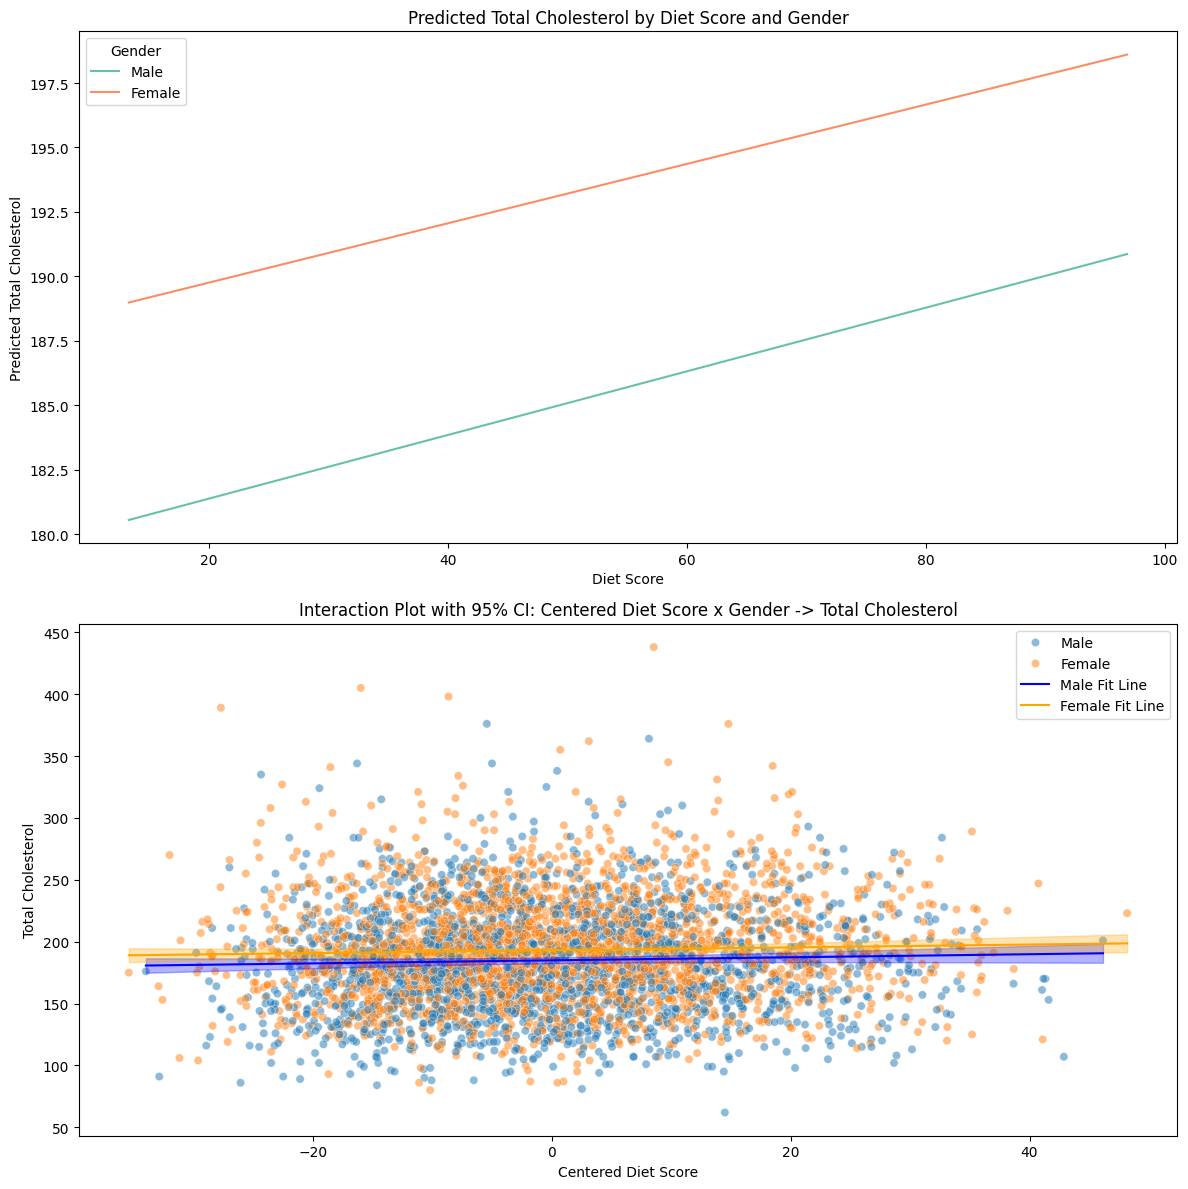

Combined_diet_cholesterol_by_gender_plot saved to: outputs\plots\obj_2.2_combined_diet_cholesterol_by_gender.png


In [8]:
# Get unique gender categories
genders = interaction_df['gender'].unique()

# Create diet score range for prediction (centered)
diet_mean = interaction_df['hei_score'].mean()
diet_range = np.linspace(interaction_df['hei_score'].min(), interaction_df['hei_score'].max(), 100)
diet_range_c = diet_range - diet_mean

# Build prediction DataFrame
predict_df = pd.DataFrame([
    {'hei_score_c': d, 'gender': g} for g in genders for d in diet_range_c
])
predict_df['gender'] = predict_df['gender'].astype(interaction_df['gender'].dtype)
predict_df['predicted_total_cholesterol'] = results.predict(predict_df)
predict_df['hei_score'] = predict_df['hei_score_c'] + diet_mean

# Prepare combined figure with 2 rows and 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=False)

# First subplot: Lineplot of predicted values
sns.lineplot(
    data=predict_df, 
    x='hei_score', 
    y='predicted_total_cholesterol', 
    hue='gender', 
    palette='Set2', 
    ax=axes[0]
)
axes[0].set_title('Predicted Total Cholesterol by Diet Score and Gender')
axes[0].set_xlabel('Diet Score')
axes[0].set_ylabel('Predicted Total Cholesterol')
axes[0].legend(title='Gender')

# Second subplot: Scatterplot + Fit Lines with Confidence Intervals
sns.scatterplot(
    data=interaction_df, 
    x='hei_score_c', 
    y='total_cholesterol', 
    hue='gender', 
    alpha=0.5, 
    ax=axes[1]
)

colors = {'Male': 'blue', 'Female': 'orange'}

for gender in genders:
    subset = interaction_df[interaction_df['gender'] == gender]
    sorted_idx = subset['hei_score_c'].argsort()
    x_sorted = subset['hei_score_c'].iloc[sorted_idx]
    
    pred_df = pd.DataFrame({
        'hei_score_c': x_sorted,
        'gender': gender
    })

    pred_res = results.get_prediction(pred_df)
    pred_summary = pred_res.summary_frame(alpha=0.05)

    axes[1].plot(x_sorted, pred_summary['mean'], color=colors[gender], label=f"{gender} Fit Line")
    axes[1].fill_between(
        x_sorted, 
        pred_summary['mean_ci_lower'], 
        pred_summary['mean_ci_upper'], 
        color=colors[gender], 
        alpha=0.3
    )

axes[1].set_title("Interaction Plot with 95% CI: Centered Diet Score x Gender -> Total Cholesterol")
axes[1].set_xlabel("Centered Diet Score")
axes[1].set_ylabel("Total Cholesterol")
axes[1].legend()

# Layout and save
plt.tight_layout()
combined_plot_path = PLOTS_DIR / "obj_2.2_combined_diet_cholesterol_by_gender.png"
plt.savefig(combined_plot_path)
plt.show()
plt.close()

print(f"Combined_diet_cholesterol_by_gender_plot saved to: {pretty_path(combined_plot_path)}")


### 4a. Combined Effect Model: Diet Score and Gender on Diabetes Probability

***Does Diet Quality Affect Diabetes Risk Differently by Gender?***

I started by selecting the data with information on diabetes status, gender, diet quality (HEI score), and the proper survey weights. I made sure there were no missing values in these key columns to keep the analysis clean. The diabetes status was coded as 0 or 1, representing whether someone does not have or has diabetes. I confirmed this coding was correct. Next, I made sure the diet quality score was numeric and dropped any rows where it wasn’t valid. After this preparation, I checked how many participants had diabetes versus those who didn’t to understand the balance of the data.
Then, I ran a logistic regression to see if diet quality (HEI score) was linked to the odds of having diabetes, while also testing if this relationship differs by gender. The model used survey weights to properly represent the population. 
Finally, I printed the results summary to see which factors were significant and how strong their effects were. This approach helps us understand not just whether better diet lowers diabetes risk, but also if that protective effect varies between men and women.

In [9]:
# 1. Filter and prepare the data
diabetes_df = df.dropna(subset=["diabetes_status", "gender", "hei_score", "interview_sample_weight"]).copy()

# 2. Check unique values of diabetes_status to ensure clean mapping
print("Unique diabetes_status values:", diabetes_df["diabetes_status"].unique())

# 3. Convert diabetes_status to integer (expects 0 and 1 only)
diabetes_df["diabetes_binary"] = diabetes_df["diabetes_status"].astype(int)

# 4. Convert hei_score to numeric, coerce errors to NaN
diabetes_df["hei_score"] = pd.to_numeric(diabetes_df["hei_score"], errors="coerce")

# 5. Drop rows with missing hei_score after conversion
diabetes_df = diabetes_df.dropna(subset=["hei_score"])

# 6. Check distribution of binary target
print("diabetes_binary value counts:")
print(diabetes_df["diabetes_binary"].value_counts())

# 7. Fit GLM logistic regression with interaction term and sampling weights
model = smf.glm(
    formula="diabetes_binary ~ hei_score * gender",
    data=diabetes_df,
    family=sm.families.Binomial(),
    freq_weights=diabetes_df["interview_sample_weight"]
).fit(cov_type='HC3')

# 8. Print model summary
print(model.summary())


Unique diabetes_status values: [0. 1.]
diabetes_binary value counts:
diabetes_binary
0    4036
1     757
Name: count, dtype: int64
                 Generalized Linear Model Regression Results                  
Dep. Variable:        diabetes_binary   No. Observations:                 4793
Model:                            GLM   Df Residuals:             145395234.74
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.6595e+07
Date:                Sat, 26 Jul 2025   Deviance:                   1.1319e+08
Time:                        14:38:50   Pearson chi2:                 1.45e+08
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.02

### 4b. Combined Effect Model: Diet Score and Gender on Diabetes Probability - Visualization

***How Diet Quality and Gender Together Influence Diabetes Risk***

I created a smooth range of diet quality scores (HEI scores) that cover the whole range observed in our data. For each gender group, I combined these diet scores to predict the probability of having diabetes using the model we just fitted.
I converted the model’s output (which is in log-odds) into probabilities, which are easier to understand — basically, the chance of having diabetes. Then, I plotted these predicted diabetes probabilities across the range of diet scores separately for each gender. This visualization helps us see how the risk of diabetes changes with diet quality for men and women, letting us compare if diet affects them differently. The resulting plot was saved for review.

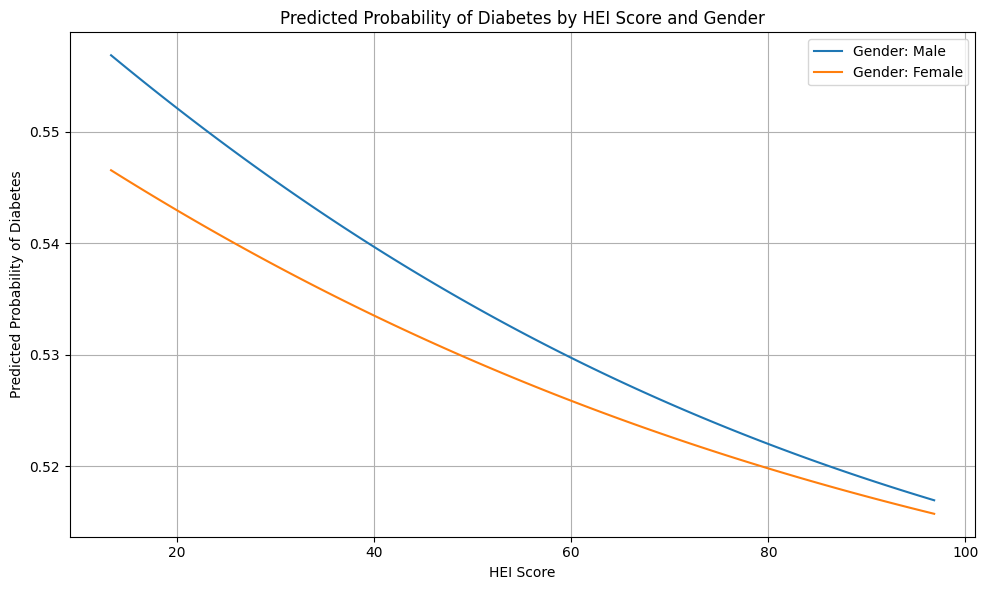

Combined Effect Model of Diet Score and Gender on Diabetes Probability saved to: outputs\plots\obj_2.2_combined_diet_score_and_gender_on_diabetes.png


In [10]:
# Prepare a range of hei_score values spanning the observed data
hei_score_range = np.linspace(diabetes_df["hei_score"].min(), diabetes_df["hei_score"].max(), 100)

# Get unique gender categories 
genders = diabetes_df["gender"].unique()

# Create DataFrame for prediction with all combinations of hei_score and gender
pred_df = pd.DataFrame([
    {"hei_score": hs, "gender": g}
    for g in genders
    for hs in hei_score_range
])

# Predict the linear predictor (log-odds)
pred_df["predicted_logit"] = model.predict(pred_df)

# Convert log-odds to probabilities using logistic function
pred_df["predicted_prob"] = 1 / (1 + np.exp(-pred_df["predicted_logit"]))

# Plotting
plt.figure(figsize=(10,6))
for g in genders:
    subset = pred_df[pred_df["gender"] == g]
    plt.plot(subset["hei_score"], subset["predicted_prob"], label=f"Gender: {g}")

plt.xlabel("HEI Score")
plt.ylabel("Predicted Probability of Diabetes")
plt.title("Predicted Probability of Diabetes by HEI Score and Gender")
plt.legend()
plt.grid(True)
plt.tight_layout()
plot_path = PLOTS_DIR / "obj_2.2_combined_diet_score_and_gender_on_diabetes.png"
plt.savefig(plot_path)
plt.show()
plt.close()

print(f"Combined Effect Model of Diet Score and Gender on Diabetes Probability saved to: {pretty_path(plot_path)}")
